# Graph Neural Networks for Flow Field Reconstruction

## Overview

This tutorial gives a methodology for the building of a simple Graph Neural Networks (GNNs).


### Learning Objectives
1. 
2. 
3. 


### References

- Battaglia et al. (2018): Relational inductive biases, deep learning, and graph networks. https://arxiv.org/abs/1806.01261 
- Lino et al. (2022): Multi-scale rotation-equivariant graph neural networks for unsteady Eulerian fluid dynamics. https://pubs.aip.org/aip/pof/article/34/8/087110/2847850 


### Code

- Attapted from https://github.com/archied2804/graphs4cfd_cardiac, a fork from the graphs4cfd library developed by Mario Lino, https://github.com/mario-linov/graphs4cfd.


---

## 1. Introduction


For the purpose of this tutorial we will use the formalism described by Battaglia et al., using a 'graph' to mean a "directed, attributed multi-graph with a global attribute".

Specifically, as in their notation, our graph data structure has the form $G = (\mathbf{u}, V, E)$, where $\mathbf{u}$ is our global attribute, $V = \{\mathbf{v}_i\}_{i=1:N^v}$ the set of node attributes attached to each node, and $E = \{(\mathbf{e}_k,r_k,s_k)\}_{k=1:N^e}$ the set of edges, each described by the coordinates of the send and receive nodes to which the said edge corresponds.

Traditional CFD methods (finite element, finite volume) discretise physical domains into meshes. Graph Neural Networks provide a natural framework for learning on these mesh-based representations:

- **Nodes** represent spatial locations (mesh vertices)
- **Edges** represent spatial relationships (connectivity)
- **Node features** encode physical quantities (velocity, pressure, etc.)
- **Edge features** encode geometric relationships (distance, relative positions)

<p align="center">
  
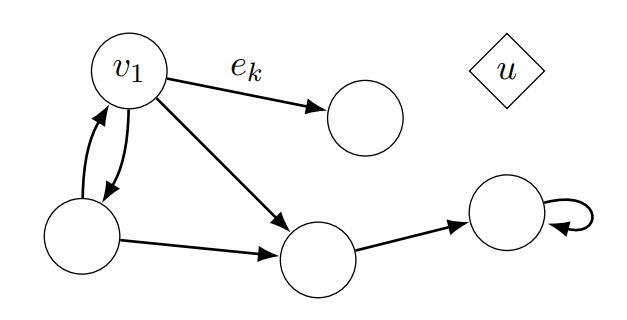

</p>


## 2. Methodology

a
a
a
a
a


# Importing Libraries and Data

This tutorial will be developed using the PyG (Pytorch Geometric) Library built upon PyTorch.

PyTorch - https://pytorch.org/ 

PyTorch Geometric - https://pytorch-geometric.readthedocs.io/en/latest/

From this the attached library ```GNN_4_CFD``` has been built, this has been developed using the code from [Mario Lino](https://pubs.aip.org/aip/pof/article/34/8/087110/2847850/Multi-scale-rotation-equivariant-graph-neural), built for his work developing Rotationally-Equivarient GNNs.

For a full understanding of the code reading through the code in the ```GNN_4_CFD``` library, namely the GNN class in ```./GNN_4_CFD/nn/model.py```

.
├── GNN_4_CFD/
│   ├── cfd_dataset.py
│   ├── data_loader.py
│   ├── graph.py
│   ├── __init__.py
│   ├── metrics.py
│   ├── model.py
│   ├── nn/
│   │   ├── blocks.py
│   │   ├── GNN_Architect.py
│   │   ├── __init__.py
│   │   ├── losses.py
│   │   ├── model.py
│   │   └── UniversalGNN.py
│   └── transforms/
│       ├── connect.py
│       ├── geometric.py
│       ├── __init__.py
│       ├── interpolate.py
│       ├── noise.py
│       ├── scale.py
│       └── subset.py
├── GNN_Tutorial_AIRTUK.ipynb
├── main.py
├── pyproject.toml
├── README.md
└── uv.lock


## 1. Libraries

In [1]:
import sys
print(sys.executable)

/home/m22729ad/Projects-Local/AIRTUK_GNN/.venv/bin/python


In [2]:
import torch
import torch_geometric
from torchvision import transforms
import numpy as np
import GNN_4_CFD as gfd
from GNN_4_CFD.nn.GNN_Architect import GNNArchBuilder, MultiScaleGNNBuilder

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print('Device:', device, 'is being used')

Device: cuda:0 is being used


## 2. Data Representation

The data for this tutorial has been collected using Nektar++, this is a spectral/hp element framework for high-accuracy data generation that includes a numerical solver.

C. D. Cantwell, D. Moxey, A. Comerford, A. Bolis, G. Rocco, G. Mengaldo, D. De Grazia, S. Yakovlev, J-E. Lombard, D. Ekelschot, B. Jordi, H. Xu, Y. Mohamied, C. Eskilsson, B. Nelson, P. Vos, C. Biotto, R. M. Kirby, and S. J. Sherwin, “Nektar++: An open-source spectral/hp element framework,” Computer physics communications, vol. 192, pp. 205-219, 2015.

This dataset provides solutions to the 2D Incompressible Navier–Stokes equations, capturing the spatiotemporal evolution of velocity ($u, v$) and pressure ($p$) fields as fluid passes through a vertical array of cylinders.

1. Physics & Flow Regime
The simulations focus on laminar vortex shedding—a periodic oscillating flow occurring behind the cylinders.
- Governing Equations: The system is modeled by the incompressible Navier–Stokes equations and the incompressibility condition.
- Temporal State: Data snapshots begin at $t_0$, selected only after the flow reaches a periodic steady-state.
- Sampling: Snapshots are captured at a fixed interval of $\Delta t = 0.2$.

2. Parameters & Variables
The dataset varies geometry and flow conditions to enable the training of generalized models (e.g., Operator Learning).

| Parameter | Symbol | Value |
|-----------|--------|-------|
|RangeCylinder | Diameter$D$ | $1$ (Normalized) |
|Center-to-Center Spacing|$H$|Randomly sampled $4D$ to $6D$|
|Reynolds Number|$Re$|Varied to maintain laminar shedding|
|State Variables|$\mathbf{u, v}, p$|Horizontal velocity, Vertical velocity, Pressure|
|Time Step|$\Delta t$|0.2

3. Boundary Conditions (BCs)
The domain is configured to simulate an infinite vertical column:
- Inlet (Left): Dirichlet BC ($u=1, v=0$).
- Outlet (Right): Standard outflow ($\frac{\partial \mathbf{u}}{\partial x} = 0, p=0$).
- Top/Bottom: Periodic, allowing flow to cycle vertically.
- Cylinder Walls: No-slip ($\mathbf{u}=0$).



## 3. Visualising the Data

First we load the dataset in

In [4]:
# Locate Training Data
path_to_ellipse_data = '/home/m22729ad/Projects-Local/AIRTUK_GNN/uvpAroundEllipseThin.h5'

# Setup your training info
info = {"n_in": 2, "n_out": 1, "step": 1, "T": 100}

# Initialise dataset
ellipse_data = gfd.cfd_dataset.NsEllipse('uvp', path=path_to_ellipse_data, training_info=info)

print(f'Number of samples in ellipse_data: {len(ellipse_data)}')

Number of samples in ellipse_data: 50


Then we can visualise the shape of the dataset, for more information on how this is read in see ```GNN_4_CFD/cfd_dataset.py```

In [5]:
# 1. Quick readout
print(ellipse_data) 
# Output: <NsCircle (samples=100, path=data.h5)>

# 2. Detailed structure readout
ellipse_data.summary()

<NsEllipse (samples=50, path=/home/m22729ad/Projects-Local/AIRTUK_GNN/uvpAroundEllipseThin.h5)>
------------------------------
DATASET STRUCTURE: NsEllipse
------------------------------
File Path:       /home/m22729ad/Projects-Local/AIRTUK_GNN/uvpAroundEllipseThin.h5
Total Samples:   50
Nodes per Mesh:  3994
Features/Time:   610
Preloaded:       False

TRAINING CONFIGURATION:
  n_in        : 2
  n_out       : 1
  step        : 1
  T           : 100
  Seq Length:   3 (total steps needed)
------------------------------

DATA MAPPING (NsCircle):
  Cols [0:2]:    Position (x, y)
  Col  [2]:      Global Parameter (Re)
  Col  [3]:      Boundary Condition ID
  Cols [4:]:     Field Data (u, v, p) interleaved over time

GRAPH OUTPUT STRUCTURE:
  Input Channels:  6 (2 steps * 3 vars)
  Target Channels: 3 (1 steps * 3 vars)
------------------------------


Now we can visualise the flow fields

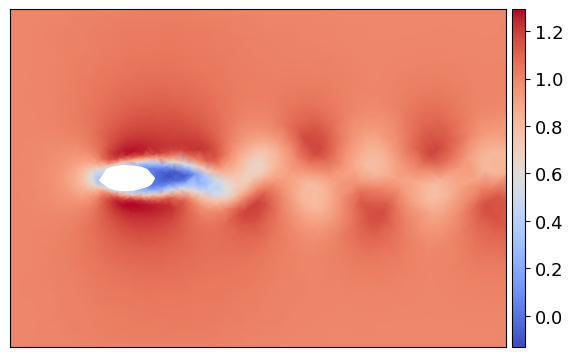

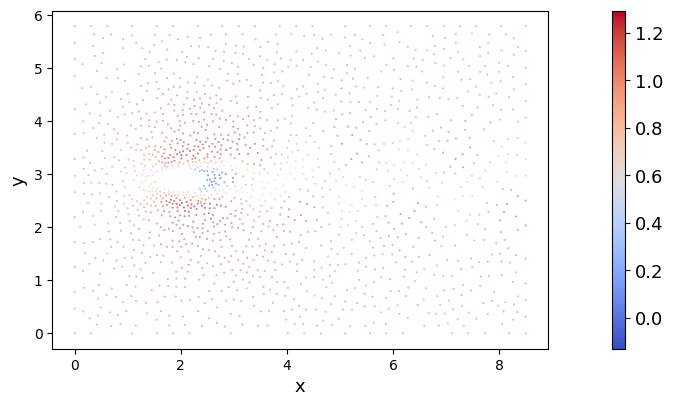

In [6]:
graph = ellipse_data.get_sequence(1,1)

gfd.process.plot.field(graph.pos, graph.target[:,0], bound=graph.bound)

gfd.process.plot.pos_field(graph.pos, graph.target[:,0])

# Using the Code

## 3. Network Architecture

The network architecture exploited in this tutorial is built on the formulation provided by Battaglia et al. \cite...

### 3.1. The Graph Network (GN) Block

The GN block is the engine of the network, defining how information moves between nodes (points), edges (connections), and global attributes (the whole system). It uses a two-step MLP process:

- Edge Update ($\phi^e$): Computes the "message" or signal passing between two nodes based on their current states and any global influences.
- Aggregation ($\rho^{e \rightarrow v}$): Collects all incoming messages for a node. Crucially, this step is permutation-invariant, meaning the result is independent of the order in which neighbor data is processed.
- Node Update ($\phi^v$): Updates the node’s properties (e.g., voltage) based on its previous state and the aggregated messages.

\[
\begin{aligned}
e'_k &= \phi^e(e_k, v_{r_k}, v_{s_k}, u) \\
v'_i &= \phi^v(\bar{e}'_i, v_i, u) \\
u'   &= \phi^u(\bar{e}', \bar{v}', u) \\
\bar{e}'_i &= \rho^{e \rightarrow v}(E'_i) \\
\bar{e}'   &= \rho^{e \rightarrow u}(E') \\
\bar{v}'   &= \rho^{v \rightarrow u}(V')
\end{aligned}
\]

### 3.3. Multi-scale Architectures

To handle large systems efficiently, the MuS-GNN creates lower-resolution versions of the graph. By "coarsening" the data into smaller subsets, the network can pass messages over greater distances more quickly, capturing both fine-grained details and big-picture trends.

<p align="center">

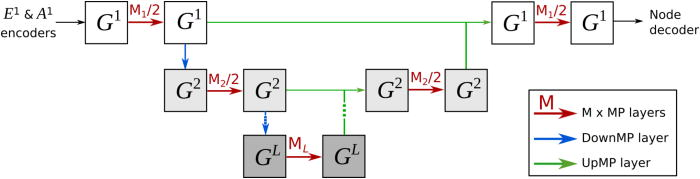

</p>

The multi-scale architecture 

## 4.1 Single Scale Implementation



Defining the architecture

In [7]:
# Model definition 

arch_parameters = {
    "num_mp_blocks": 4,
    "hidden_dim": 128,
    "edge_encoder_in": 2,
    "node_encoder_in": 4,
    "decoder_out": 3,
    "mlp_depth": 3
}

print("="*80)
print("SINGLE-SCALE GNN EXAMPLE")
print("="*80)

# Build single-scale GNN with 8 MP blocks
builder = GNNArchBuilder(arch_parameters)

print(builder.summary())
arch = builder.build_single_scale()

print("\nGenerated architecture keys:")
for key in arch:
    print(f"  {key}: {arch[key]}")

print("\n" + "="*80)
print("MULTI-SCALE GNN EXAMPLE (3 scales)")
print("="*80)

SINGLE-SCALE GNN EXAMPLE


ValueError: Length of hidden_dim list (1) must match num_mp_blocks ((4,))

Training Configuration

In [ ]:
def generate_model_name(config_dict, test_number=1):
    """Generates a descriptive name: Scale-Blocks-Dim-Test#"""
    scales = arch_parameters.get('num_scales', 1)
    blocks = arch_parameters.get('mp_blocks_per_scale', config_dict.get('num_mp_blocks'))
    hidden = arch_parameters.get('hidden_dims', config_dict.get('hidden_dim'))
    
    name = f"GNN_S{scales}_B{blocks}_H{hidden}_T{test_number:02d}"
    return name

In [ ]:
# Example of streamlined setup in your tutorial notebook/script

test_id = 1
model_name = generate_model_name(arch_parameters, test_number=test_id)
print(model_name)

# Training configuration
train_config = gfd.nn.TrainConfig(
    name            = model_name,
    folder          = './checkpoints',
    tensor_board    = './logs',
    chk_interval    = 1,
    training_loss   = gfd.nn.losses.GraphLoss(lambda_d=0.25),
    validation_loss = gfd.nn.losses.GraphLoss(),
    epochs          = 10,
    num_steps       = [i for i in range(1,11)],
    add_steps       = {'tolerance': 0.005, 'loss': 'training'},
    batch_size      = 8,
    lr              = 1e-5,
    grad_clip       = {"epoch": 0, "limit": 1},
    scheduler       = {"factor": 0.5, "patience": 5, "loss": 'training'},
    stopping        = 1e-8,
    device          = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

Dataset Loading

In [ ]:

# Training datasets
path_to_ellipse_data = '/home/m22729ad/Projects-Local/AIRTUK_GNN/uvpAroundEllipseThin.h5'  # full dataset at https://zenodo.org/records/7870707 or https://huggingface.co/datasets/mariolinov/Ellipse/tree/main

# Transforms to apply to the data
transform = transforms.Compose([
    gfd.transforms.ConnectKNN(6, period=[None, "auto"]),
    #gfd.transforms.ScaleNs({'u': (-2.1,2.6), 'v': (-2.25,2.1), 'p': (-3.7,2.35), 'Re': (500,1000)}, format='uvp'),
    #gfd.transforms.ScaleEdgeAttr(0.1),
    #gfd.transforms.RandomGraphRotation(eq='ns', format='uvp'),
    #gfd.transforms.RandomGraphFlip(eq='ns', format='uvp'),
    #gfd.transforms.AddUniformNoise(0.01)
])

# Transforms to apply to the batches
#batch_transform = transforms.Compose([
#    gfd.transforms.GridClustering([0.15]),
#])

dataset = gfd.cfd_dataset.NsEllipse(format='uvp', path=path_to_ellipse_data, training_info={"n_in":1, "n_out":train_config['num_steps'][-1], "step":1, "T":100}, transform=transform) # If enough memory, set preload=True

# Training testing data split
train_set, test_set = torch.utils.data.random_split(dataset, [0.9,0.1])

# What are the train/test loaders
train_loader = gfd.DataLoader(
    train_set,
    batch_size  = train_config['batch_size'],
    shuffle     = True,
    #transform   = batch_transform,
    num_workers = 4
)   
val_loader  = gfd.DataLoader(
    test_set, 
    batch_size  = train_config['batch_size'],
    shuffle     = False,
    #transform   = batch_transform,
    num_workers = 4
)   

Training the model

In [ ]:
model = gfd.nn.UniversalGNN(arch=arch)
print("Number of trainable parameters: ", model.num_params)


# Training
model.fit(train_config, train_loader, val_loader=val_loader)


# 5 Multiscale

In [ ]:
print("="*80)
print("SINGLE-SCALE GNN EXAMPLE")
print("="*80)

# Build single-scale GNN with 8 MP blocks
builder = GNNArchBuilder(
    num_mp_blocks=8,
    hidden_dim=128,
    edge_encoder_in=2,
    node_encoder_in=5,
    decoder_out=3,
    mlp_depth=3
)

print(builder.summary())
arch = builder.build_single_scale()

print("\nGenerated architecture keys:")
for key in arch:
    print(f"  {key}: {arch[key]}")

print("\n" + "="*80)
print("MULTI-SCALE GNN EXAMPLE (3 scales)")
print("="*80)

# Build 3-scale GNN with varying MP blocks and hidden dims
multi_builder = MultiScaleGNNBuilder(
    num_scales=3,
    mp_blocks_per_scale=[4, 4, 4],
    hidden_dims=[128, 128, 128],
    edge_encoder_in=2,
    node_encoder_in=5,
    decoder_out=3,
    mlp_depth=3,
    skip_connections=True
)

print(multi_builder.summary())
multi_arch = multi_builder.build()

print("\nGenerated architecture keys:")
for key in sorted(multi_arch.keys()):
    print(f"  {key}")


# Results and Postprocessing

In [ ]:
path_to_tensorboard = "/home/m22729ad/Projects-Local/AIRTUK_GNN/NsTwoScaleGNN/events.out.tfevents.1769776546.e-u24l854417sh.671048.0"

data = gfd.process.read_tensorboard_logs(path_to_tensorboard)

gfd.process.plot_losses(data)

In [ ]:
path_to_chk = "/home/m22729ad/Projects-Local/AIRTUK_GNN/NsTwoScaleGNN.chk"

data_chk = gfd.process.load_checkpoint(path_to_chk)

gfd.process.plot_lr(data_chk)

Flow field reconstruction visuals

In [ ]:
# NsCircle dataset (training dataset)
scaling = {'u': (-2.1,2.6), 'v': (-2.25,2.1), 'p': (-3.7,2.35), 'Re': (500,1000)} # This tuples are the (min, max) values for each variable in the training dataset
transform = transforms.Compose([
    gfd.transforms.ConnectKNN(6, period=(None,"auto")), # Detect the periodicity along the y-axis
    #gfd.transforms.ScaleNs(scaling, 'uvp'),
    #gfd.transforms.ScaleEdgeAttr(0.1),
    #gfd.transforms.GridClustering([0.15, 0.30, 0.60]), # This builds the four-scale graph
])

# NsCircleHighRe dataset (Re-extrapolation dataset)

ns_valid = gfd.cfd_dataset.NsEllipse('uvp', path=path_to_ellipse_data, transform=transform) # The format is 'uvp' because the dataset contains the velocity components and the pressure


# Print the number of samples/simulations in each dataset
print(f'Number of samples in ns_circle: {len(ns_valid)}')

In [ ]:
sample = len(ns_valid)//2 # Idx of the sample/simulation from the dataset
n_out = 4 # Number of prediction steps
graph = ns_valid.get_sequence(sample, n_out=n_out)

# Inference with each model
pred = model.solve(graph, n_out=n_out)

# Compute the coefficients of determination (R^2) for each model
r21 = gfd.metrics.r2(pred, graph.target)

# Plot the ground truth and the predicted x-component of the velocity field for the best model
print(f'Plotting the ground truth and predicted x-component of the velocity field for the model')

gfd.plot.compare_fields(graph.pos, graph.target[:,::3], pred[:,::3], bound=graph.bound)

# Extensions and Experimentation




### 3.1 Avenues for experimentaiton
- Loss function
- Model Architecture
- ...